# Практическое задание: Деревья Решений

В этом практическом задании вы будете применять знания о деревьях решений на реальных данных. Выполните задания последовательно, используя подсказки и документацию библиотек при необходимости.

## Цели практического задания:
1. Научиться подготавливать данные для деревьев решений
2. Построить и настроить модель дерева решений
3. Визуализировать и интерпретировать результаты
4. Провести оптимизацию гиперпараметров
5. Оценить производительность модели

## Задание 1: Подготовка данных

1. Импортируйте необходимые библиотеки (numpy, pandas, sklearn, etc.)
2. Загрузите датасет iris из sklearn.datasets
3. Создайте DataFrame с данными и добавьте понятные названия столбцов
4. Проведите базовый анализ данных:
   - Проверьте размер датасета
   - Изучите распределение классов
   - Постройте корреляционную матрицу
   - Визуализируйте распределение признаков

Подсказка: используйте pandas.DataFrame, seaborn.heatmap, plotly для визуализации

Размер датасета: (150, 6)
Количество объектов: 150
Количество признаков: 4
Количество классов: 3

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
 5   target_name        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB
None

Описание датасета:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000  

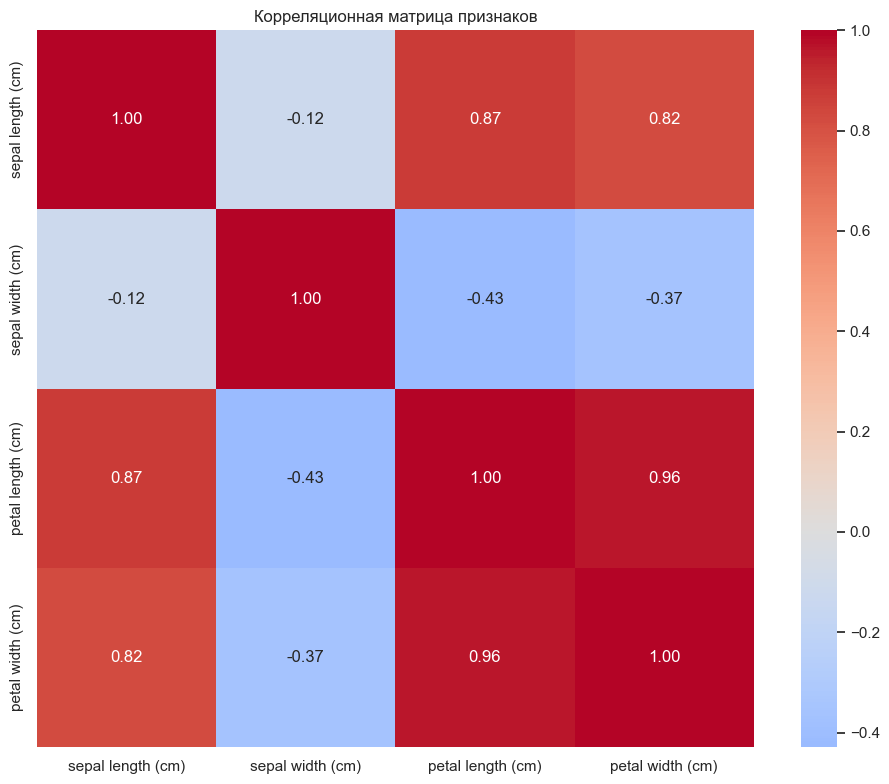

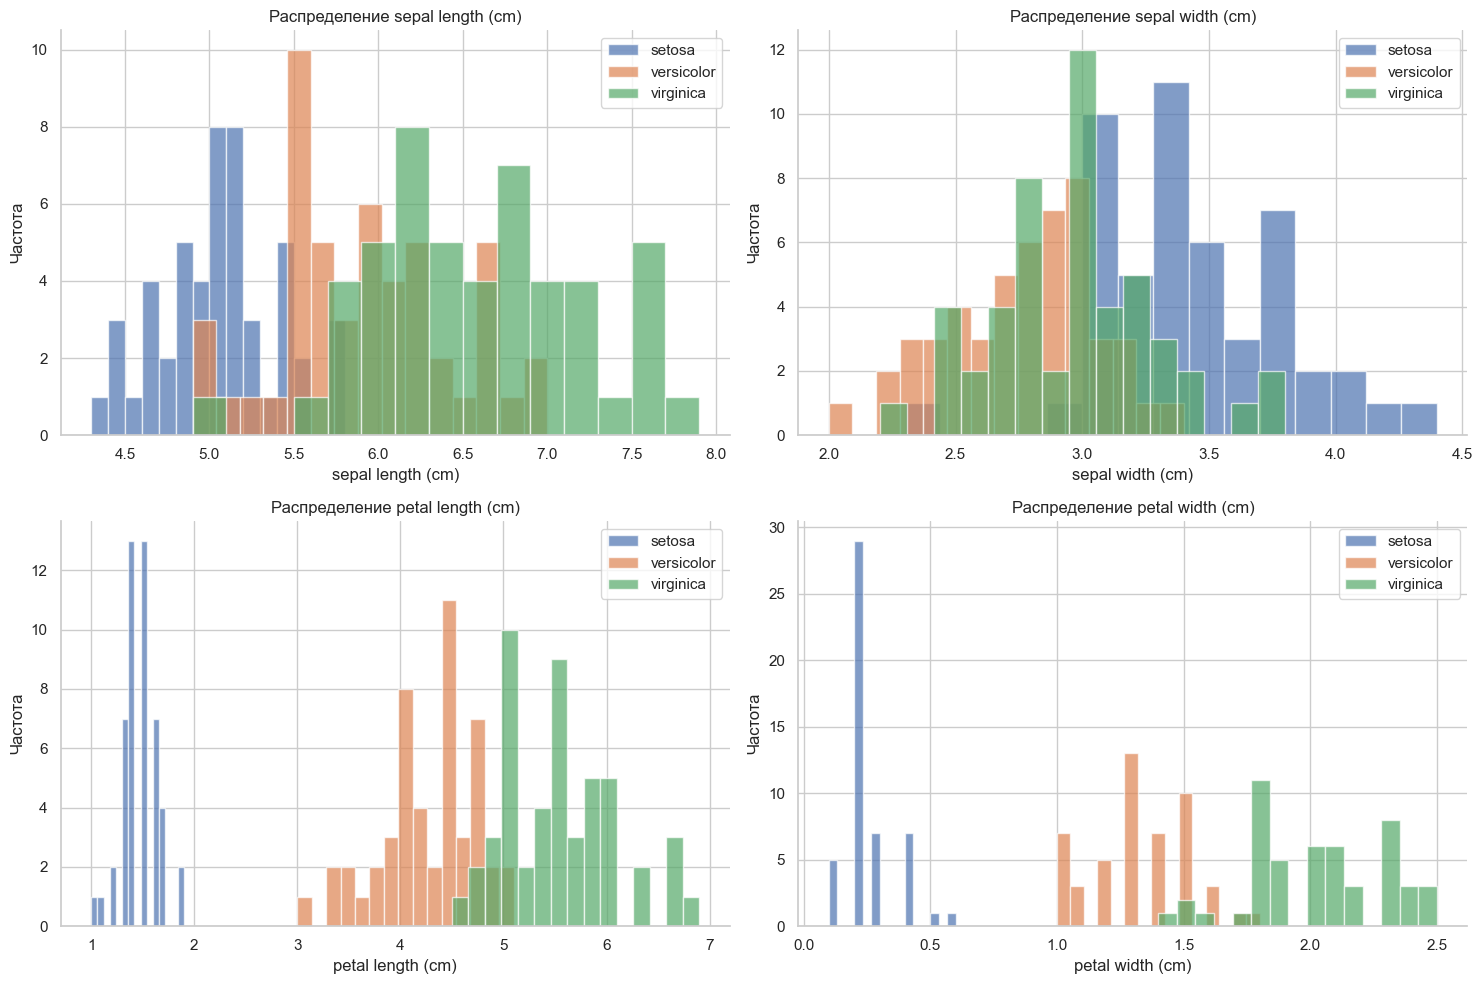

In [2]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import sklearn
from sklearn.model_selection import GridSearchCV 
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import (train_test_split, GridSearchCV, cross_val_score, 
                                   learning_curve)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                           roc_curve, auc, precision_recall_curve)
import warnings
warnings.filterwarnings('ignore')

# Настройка стиля визуализации
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# Загрузка датасета iris
dataset = load_iris()
X = pd.DataFrame(dataset.data, columns=dataset.feature_names)
y = pd.Series(dataset.target, name='target')

# Создание полного DataFrame с данными и целевой переменной
df = pd.concat([X, y], axis=1)
df['target_name'] = df['target'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

# Базовый анализ данных
print(f"Размер датасета: {df.shape}")
print(f"Количество объектов: {df.shape[0]}")
print(f"Количество признаков: {df.shape[1] - 2}")  # исключаем target и target_name
print(f"Количество классов: {len(np.unique(y))}")

print("\nИнформация о датасете:")
print(df.info())
print("\nОписание датасета:")
print(+df.describe())

# Изучение распределения классов
class_distribution = df['target_name'].value_counts()
print(class_distribution)
print(f"\nПроцентное соотношение:")
print((class_distribution / len(df) * 100).round(2))

# Корреляционная матрица
correlation_matrix = X.corr()
print(correlation_matrix)

# Визуализация корреляционной матрицы
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f')
plt.title('Корреляционная матрица признаков')
plt.tight_layout()
plt.show()

# Визуализация распределения признаков
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
features = X.columns
for i, feature in enumerate(features):
    row = i // 2
    col = i % 2
    
    # Гистограмма с разделением по классам
    for target_class in sorted(df['target'].unique()):
        class_name = df[df['target'] == target_class]['target_name'].iloc[0]
        data = df[df['target'] == target_class][feature]
        axes[row, col].hist(data, alpha=0.7, label=class_name, bins=15)
    
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Частота')
    axes[row, col].set_title(f'Распределение {feature}')
    axes[row, col].legend()

plt.tight_layout()
plt.show()

# Интерактивная визуализация с Plotly
# Pairplot с помощью plotly
fig = px.scatter_matrix(df, dimensions=X.columns, color='target_name',
                       title='Матрица рассеяния признаков')
fig.show()

# Boxplot для каждого признака
fig = make_subplots(rows=2, cols=2, 
                    subplot_titles=X.columns)

for i, feature in enumerate(X.columns):
    row = i // 2 + 1
    col = i % 2 + 1
    
    fig.add_trace(
        go.Box(y=df[feature], x=df['target_name'], name=feature),
        row=row, col=col
    )

fig.update_layout(height=600, showlegend=False, 
                 title_text="Boxplot распределения признаков по классам")
fig.show()

## Задание 2: Построение базовой модели

1. Разделите данные на обучающую и тестовую выборки (test_size=0.2)
2. Создайте и обучите базовое дерево решений без настройки параметров
3. Оцените точность модели на тестовой выборке
4. Выведите отчет о классификации
5. Визуализируйте полученное дерево

Подсказка: используйте train_test_split, DecisionTreeClassifier, classification_report

Форма обучающей выборки: (120, 4)
Форма тестовой выборки: (30, 4)

Точность на тестовой выборке: 0.9333

Отчет о классификации:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30


Матрица ошибок:
[[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]


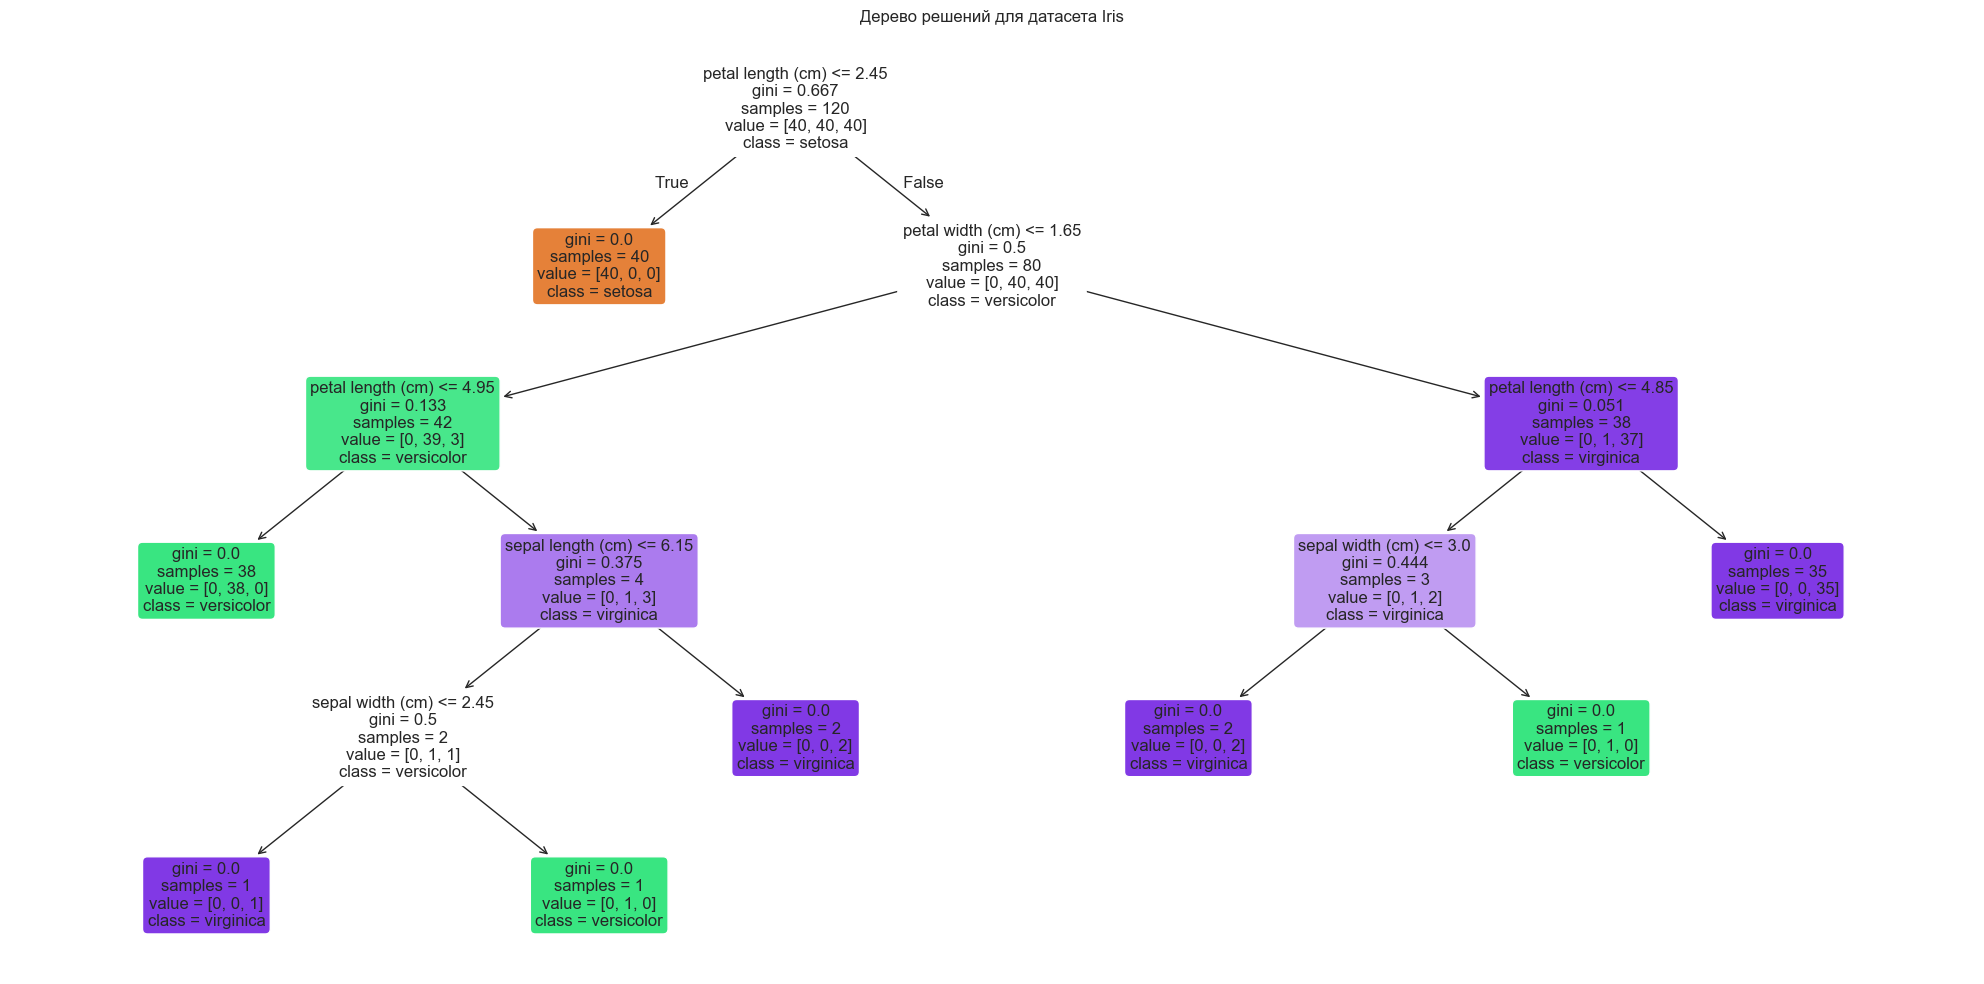

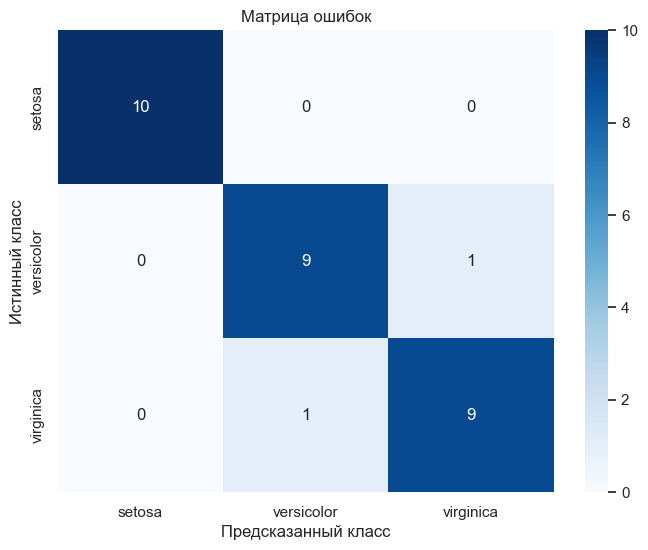

In [3]:
# Правильная подготовка данных - исключаем target_name из признаков
X_features = df.drop(['target', 'target_name'], axis=1)
y = df['target']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Форма обучающей выборки: {X_train.shape}")
print(f"Форма тестовой выборки: {X_test.shape}")

# Создание и обучение базового дерева решений
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_pred = tree_clf.predict(X_test)

# Оценка точности на тестовой выборке
accuracy = accuracy_score(y_test, y_pred)
print(f"\nТочность на тестовой выборке: {accuracy:.4f}")

# Вывод отчета о классификации
print("\nОтчет о классификации:")
target_names = ['setosa', 'versicolor', 'virginica']
print(classification_report(y_test, y_pred, target_names=target_names))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
print("\nМатрица ошибок:")
print(cm)

# Визуализация дерева решений
plt.figure(figsize=(20, 10))
plot_tree(tree_clf, 
          feature_names=X_features.columns,
          class_names=target_names,
          filled=True, 
          rounded=True,
          fontsize=12)
plt.title('Дерево решений для датасета Iris')
plt.tight_layout()
plt.show()

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=target_names,
           yticklabels=target_names)
plt.title('Матрица ошибок')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

## Задание 3: Анализ важности признаков

1. Получите и визуализируйте важность признаков из вашей модели
2. Создайте столбчатую диаграмму важности признаков
3. Постройте тепловую карту корреляций для топ-5 важных признаков
4. Проанализируйте, есть ли связь между важностью признаков и их статистическими характеристиками

Дополнительно:
- Попробуйте построить модель, используя только 2 самых важных признака
- Сравните производительность с полной моделью

Важность признаков:
             feature  importance
2  petal length (cm)    0.558568
3   petal width (cm)    0.406015
1   sepal width (cm)    0.029167
0  sepal length (cm)    0.006250


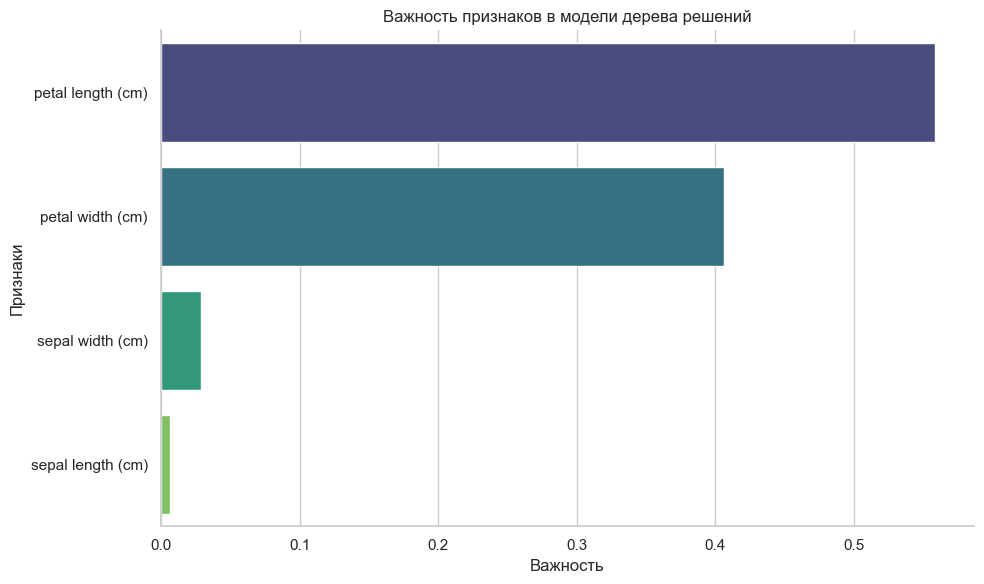

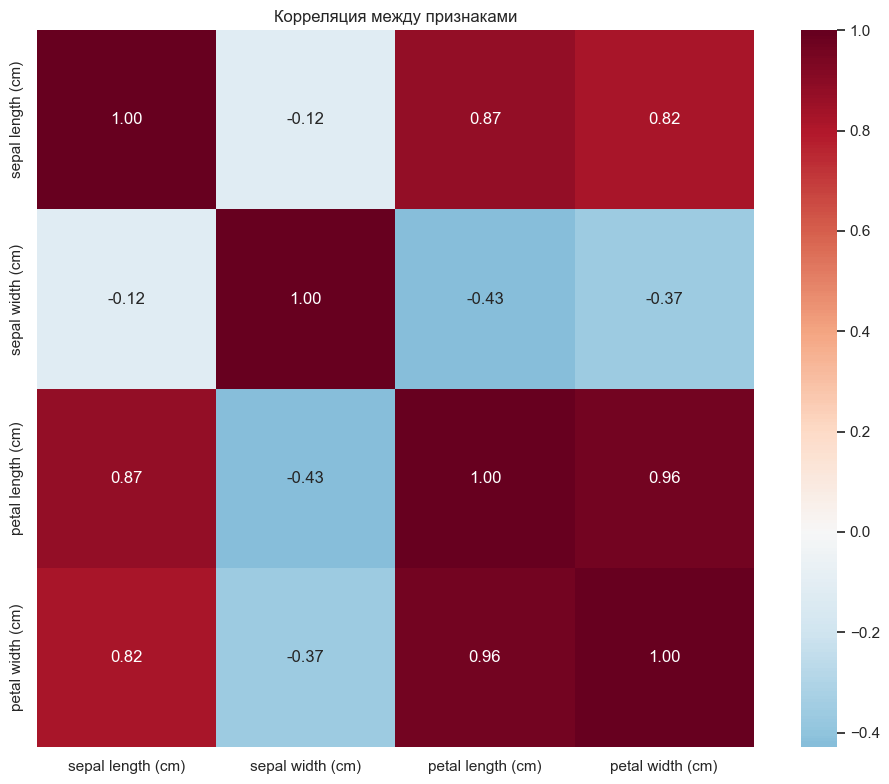


Статистики признаков и их важность:
                             feature  importance      mean       std  median
petal length (cm)  petal length (cm)    0.558568  3.758000  1.765298    4.35
petal width (cm)    petal width (cm)    0.406015  1.199333  0.762238    1.30
sepal width (cm)    sepal width (cm)    0.029167  3.057333  0.435866    3.00
sepal length (cm)  sepal length (cm)    0.006250  5.843333  0.828066    5.80

Два самых важных признака: ['petal length (cm)', 'petal width (cm)']

Точность полной модели: 0.9333
Точность модели с 2 признаками: 0.9333
Разность в точности: 0.0000


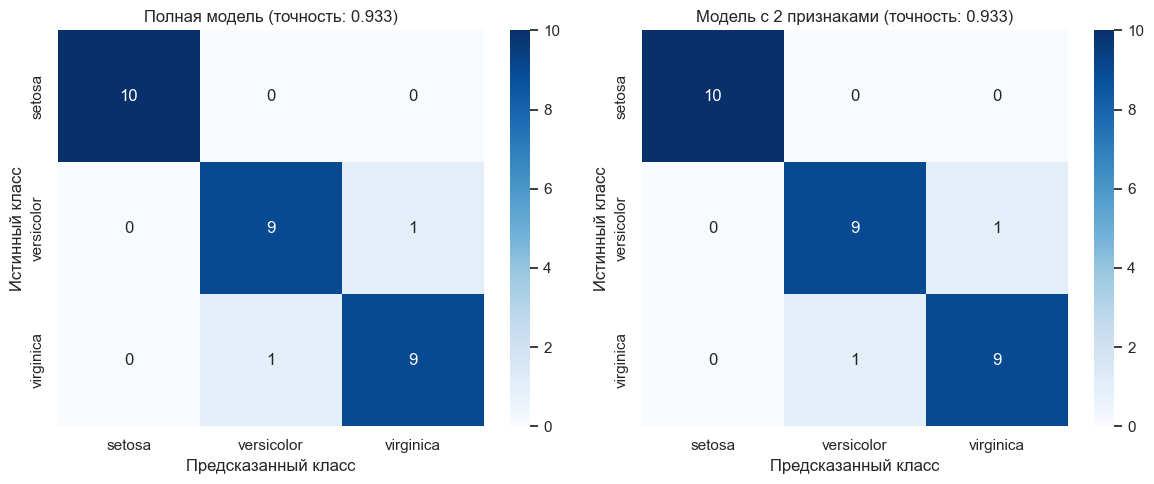

In [4]:
# Анализ важности признаков
feature_importance = pd.DataFrame({
    'feature': X_features.columns,
    'importance': tree_clf.feature_importances_
}).sort_values('importance', ascending=False)

print("Важность признаков:")
print(feature_importance)

# Создаем столбчатую диаграмму важности признаков
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title('Важность признаков в модели дерева решений')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.tight_layout()
plt.show()

# Создаем интерактивную визуализацию важности признаков
fig = go.Figure()

fig.add_trace(go.Bar(
    x=feature_importance['importance'],
    y=feature_importance['feature'],
    orientation='h',
    marker=dict(
        color=feature_importance['importance'],
        colorscale='Viridis'
    )
))

fig.update_layout(
    title='Важность признаков в модели дерева решений',
    xaxis_title='Важность',
    yaxis_title='Признак',
    height=400
)

fig.show()

# Корреляционная матрица только для признаков (без target и target_name)
correlation_matrix_features = X_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_features, 
            annot=True, 
            cmap='RdBu_r', 
            center=0,
            fmt='.2f',
            square=True)
plt.title('Корреляция между признаками')
plt.tight_layout()
plt.show()

# Анализ взаимосвязи между важностью признаков и их статистическими характеристиками
feature_stats = pd.DataFrame({
    'feature': X_features.columns,
    'importance': tree_clf.feature_importances_,
    'mean': X_features.mean(),
    'std': X_features.std(),
    'median': X_features.median()
})

# Создаем scatter plot
fig = px.scatter(feature_stats,
                x='mean',
                y='importance',
                size='std',
                text='feature',
                title='Взаимосвязь между важностью признаков и их статистическими характеристиками')

fig.update_traces(textposition='top center')
fig.show()

print("\nСтатистики признаков и их важность:")
print(feature_stats.sort_values('importance', ascending=False))

# Построение модели с 2 самыми важными признаками
top_2_features = feature_importance['feature'].head(2).tolist()
print(f"\nДва самых важных признака: {top_2_features}")

X_train_top2 = X_train[top_2_features]
X_test_top2 = X_test[top_2_features]

# Обучение модели с 2 признаками
tree_clf_top2 = DecisionTreeClassifier(random_state=42)
tree_clf_top2.fit(X_train_top2, y_train)

# Предсказания
y_pred_top2 = tree_clf_top2.predict(X_test_top2)
accuracy_top2 = accuracy_score(y_test, y_pred_top2)

print(f"\nТочность полной модели: {accuracy:.4f}")
print(f"Точность модели с 2 признаками: {accuracy_top2:.4f}")
print(f"Разность в точности: {accuracy - accuracy_top2:.4f}")

# Сравнение матриц ошибок
cm_top2 = confusion_matrix(y_test, y_pred_top2)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Полная модель
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=target_names, yticklabels=target_names,
           ax=axes[0])
axes[0].set_title(f'Полная модель (точность: {accuracy:.3f})')
axes[0].set_ylabel('Истинный класс')
axes[0].set_xlabel('Предсказанный класс')

# Модель с 2 признаками
sns.heatmap(cm_top2, annot=True, fmt='d', cmap='Blues',
           xticklabels=target_names, yticklabels=target_names,
           ax=axes[1])
axes[1].set_title(f'Модель с 2 признаками (точность: {accuracy_top2:.3f})')
axes[1].set_ylabel('Истинный класс')
axes[1].set_xlabel('Предсказанный класс')

plt.tight_layout()
plt.show()

## Задание 4: Оптимизация гиперпараметров

1. Определите сетку параметров для поиска:
   - max_depth: [3, 5, 7, 10]
   - min_samples_split: [2, 5, 10]
   - min_samples_leaf: [1, 2, 4]
   - criterion: ['gini', 'entropy']

2. Используйте GridSearchCV для поиска лучших параметров
3. Визуализируйте результаты поиска по сетке
4. Сравните производительность оптимизированной модели с базовой

Дополнительно:
- Попробуйте добавить другие параметры для оптимизации
- Используйте RandomizedSearchCV для сравнения

Лучшие параметры:
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}

Лучшая точность на кросс-валидации: 0.9417

Точность оптимизированной модели на тестовой выборке: 0.9333
Точность базовой модели: 0.9333
Улучшение: 0.0000

Топ-10 лучших комбинаций параметров:
                                               params  mean_test_score  \
9   {'criterion': 'gini', 'max_depth': 5, 'min_sam...         0.941667   
18  {'criterion': 'gini', 'max_depth': 7, 'min_sam...         0.941667   
27  {'criterion': 'gini', 'max_depth': 10, 'min_sa...         0.941667   
0   {'criterion': 'gini', 'max_depth': 3, 'min_sam...         0.933333   
1   {'criterion': 'gini', 'max_depth': 3, 'min_sam...         0.933333   
2   {'criterion': 'gini', 'max_depth': 3, 'min_sam...         0.933333   
3   {'criterion': 'gini', 'max_depth': 3, 'min_sam...         0.933333   
4   {'criterion': 'gini', 'max_depth': 3, 'min_sam...         0.933333   
5   {'criterion': 'gini', 'max_depth'

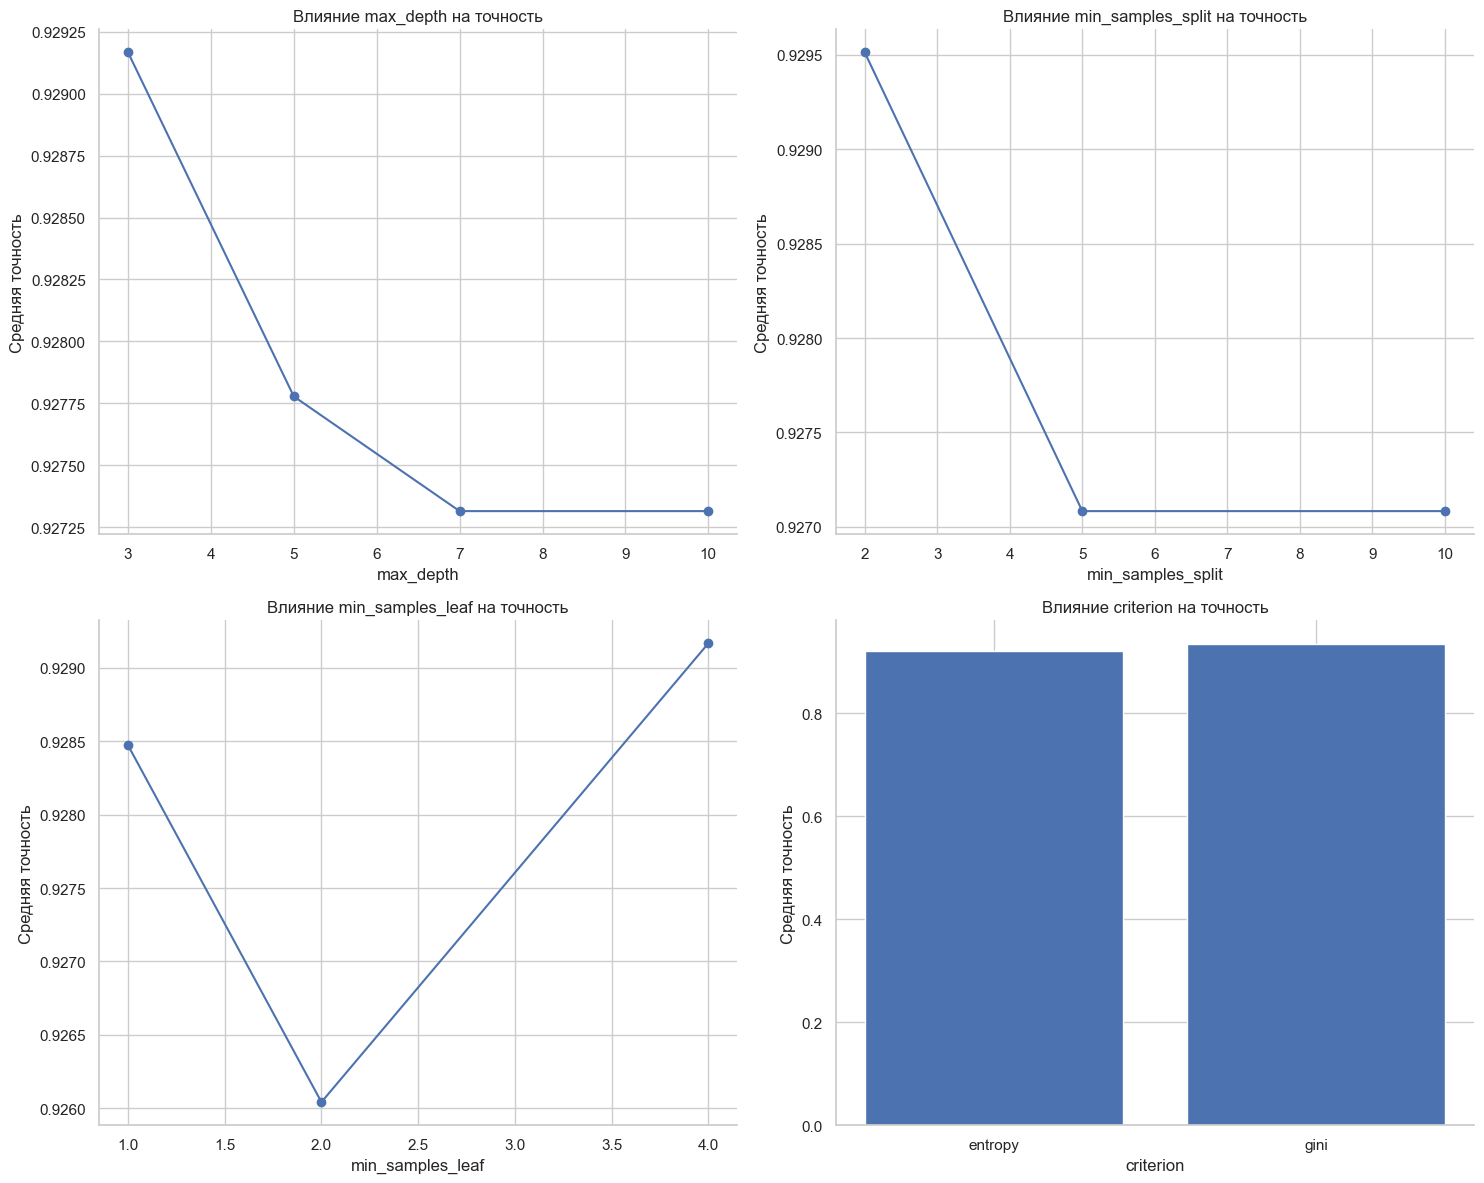

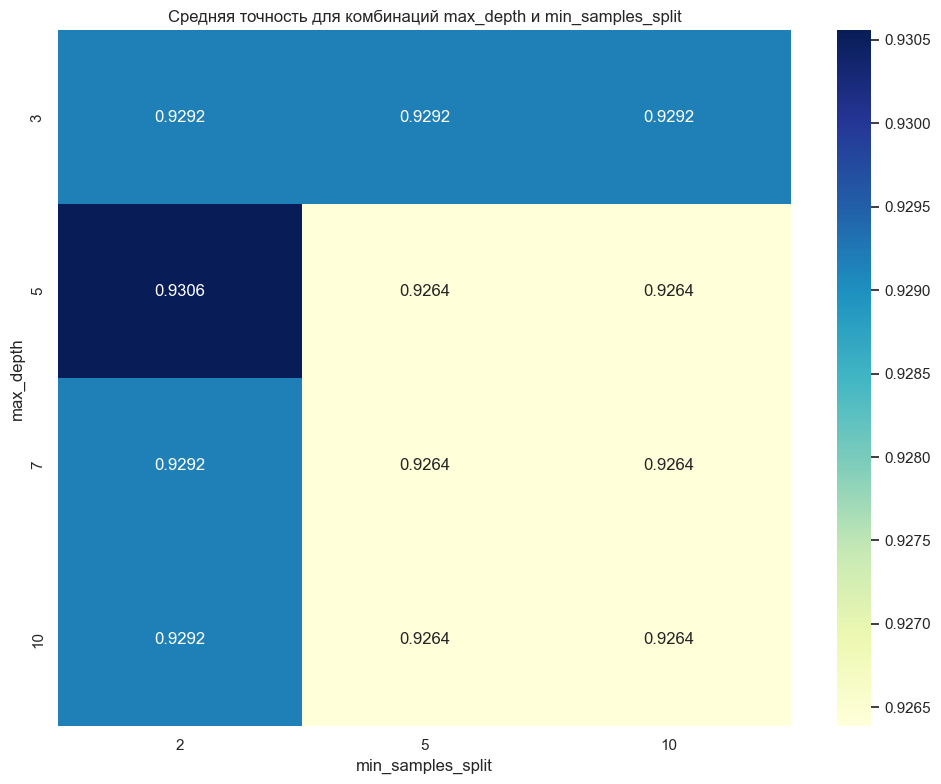

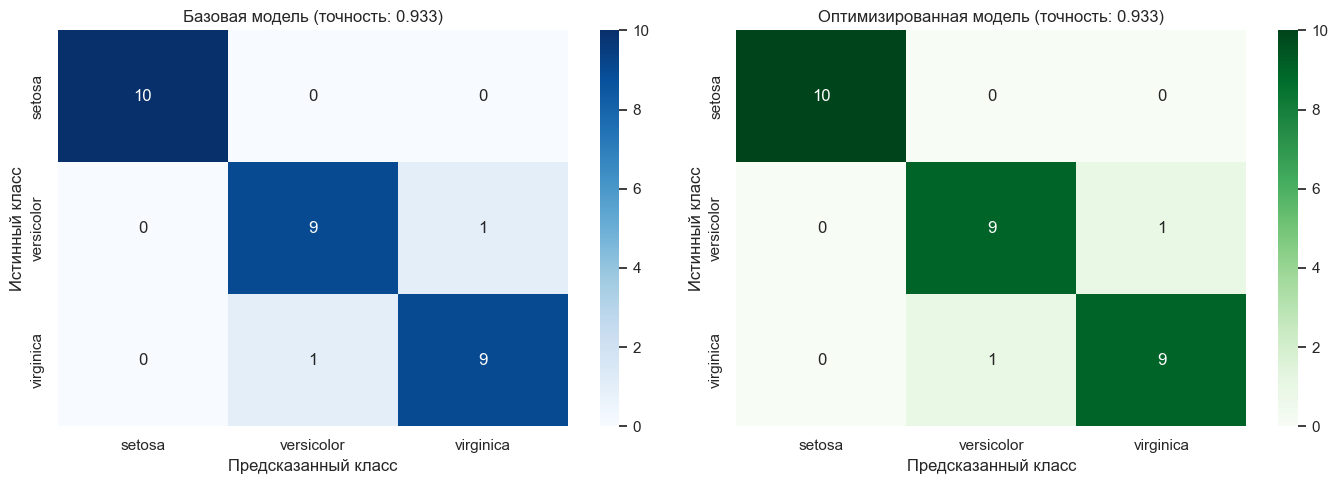


Отчет о классификации (оптимизированная модель):
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



In [5]:
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Выполняем поиск по сетке
grid_search.fit(X_train, y_train)

# Лучшие параметры
print("Лучшие параметры:")
print(grid_search.best_params_)
print(f"\nЛучшая точность на кросс-валидации: {grid_search.best_score_:.4f}")

# Обучаем модель с лучшими параметрами
best_tree_clf = grid_search.best_estimator_

# Предсказания оптимизированной модели
y_pred_best = best_tree_clf.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)

print(f"\nТочность оптимизированной модели на тестовой выборке: {accuracy_best:.4f}")
print(f"Точность базовой модели: {accuracy:.4f}")
print(f"Улучшение: {accuracy_best - accuracy:.4f}")

# Визуализация результатов GridSearch
results_df = pd.DataFrame(grid_search.cv_results_)

# Топ-10 лучших комбинаций параметров
top_results = results_df.nsmallest(10, 'rank_test_score')[
    ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
]
print("\nТоп-10 лучших комбинаций параметров:")
print(top_results)

# Визуализация влияния параметров
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# max_depth
max_depth_scores = results_df.groupby('param_max_depth')['mean_test_score'].mean()
axes[0, 0].plot(max_depth_scores.index, max_depth_scores.values, marker='o')
axes[0, 0].set_xlabel('max_depth')
axes[0, 0].set_ylabel('Средняя точность')
axes[0, 0].set_title('Влияние max_depth на точность')
axes[0, 0].grid(True)

# min_samples_split
min_samples_split_scores = results_df.groupby('param_min_samples_split')['mean_test_score'].mean()
axes[0, 1].plot(min_samples_split_scores.index, min_samples_split_scores.values, marker='o')
axes[0, 1].set_xlabel('min_samples_split')
axes[0, 1].set_ylabel('Средняя точность')
axes[0, 1].set_title('Влияние min_samples_split на точность')
axes[0, 1].grid(True)

# min_samples_leaf
min_samples_leaf_scores = results_df.groupby('param_min_samples_leaf')['mean_test_score'].mean()
axes[1, 0].plot(min_samples_leaf_scores.index, min_samples_leaf_scores.values, marker='o')
axes[1, 0].set_xlabel('min_samples_leaf')
axes[1, 0].set_ylabel('Средняя точность')
axes[1, 0].set_title('Влияние min_samples_leaf на точность')
axes[1, 0].grid(True)

# criterion
criterion_scores = results_df.groupby('param_criterion')['mean_test_score'].mean()
axes[1, 1].bar(range(len(criterion_scores)), criterion_scores.values)
axes[1, 1].set_xticks(range(len(criterion_scores)))
axes[1, 1].set_xticklabels(criterion_scores.index)
axes[1, 1].set_xlabel('criterion')
axes[1, 1].set_ylabel('Средняя точность')
axes[1, 1].set_title('Влияние criterion на точность')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Heatmap для комбинаций двух параметров
pivot_table = results_df.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_min_samples_split',
    aggfunc='mean'
)

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt='.4f', cmap='YlGnBu')
plt.title('Средняя точность для комбинаций max_depth и min_samples_split')
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')
plt.tight_layout()
plt.show()

# Сравнение матриц ошибок
cm_best = confusion_matrix(y_test, y_pred_best)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=target_names, yticklabels=target_names,
           ax=axes[0])
axes[0].set_title(f'Базовая модель (точность: {accuracy:.3f})')
axes[0].set_ylabel('Истинный класс')
axes[0].set_xlabel('Предсказанный класс')

sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens',
           xticklabels=target_names, yticklabels=target_names,
           ax=axes[1])
axes[1].set_title(f'Оптимизированная модель (точность: {accuracy_best:.3f})')
axes[1].set_ylabel('Истинный класс')
axes[1].set_xlabel('Предсказанный класс')

plt.tight_layout()
plt.show()

# Отчет о классификации для оптимизированной модели
print("\nОтчет о классификации (оптимизированная модель):")
print(classification_report(y_test, y_pred_best, target_names=target_names))

## Задание 5: Оценка модели

1. Постройте кривые обучения для оптимизированной модели
2. Создайте и визуализируйте:
   - ROC-кривую
   - Precision-Recall кривую
   - Матрицу ошибок

3. Проанализируйте результаты:
   - Есть ли признаки переобучения?
   - Какие классы предсказываются лучше/хуже?
   - Какие метрики наиболее важны для данной задачи?

Дополнительно:
- Попробуйте применить cross_val_score с разным количеством фолдов
- Сравните результаты с другими алгоритмами классификации

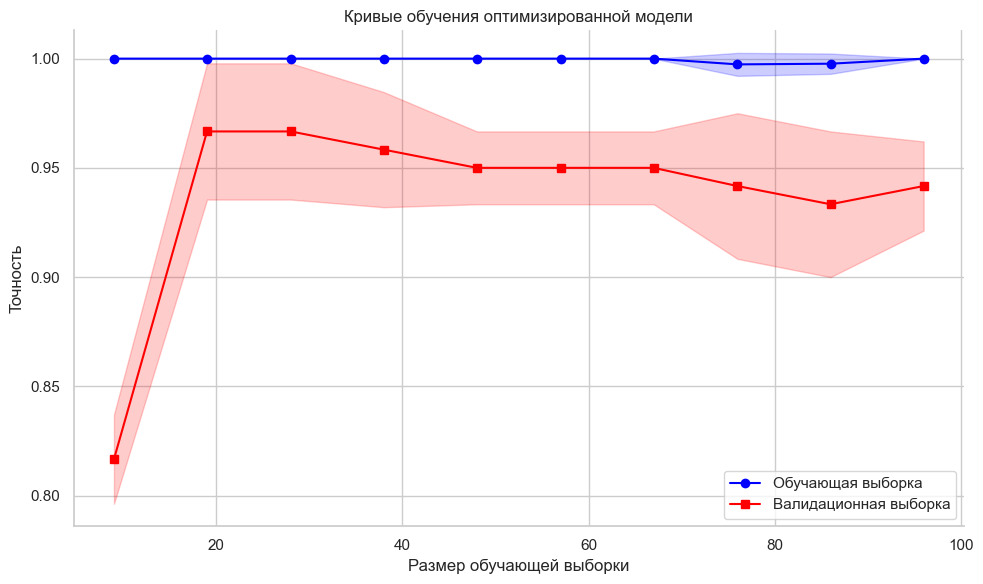

Точность на обучающей выборке: 1.0000 ± 0.0000
Точность на валидационной выборке: 0.9417 ± 0.0204
Разница (признак переобучения): 0.0583
⚠️ Присутствуют признаки переобучения


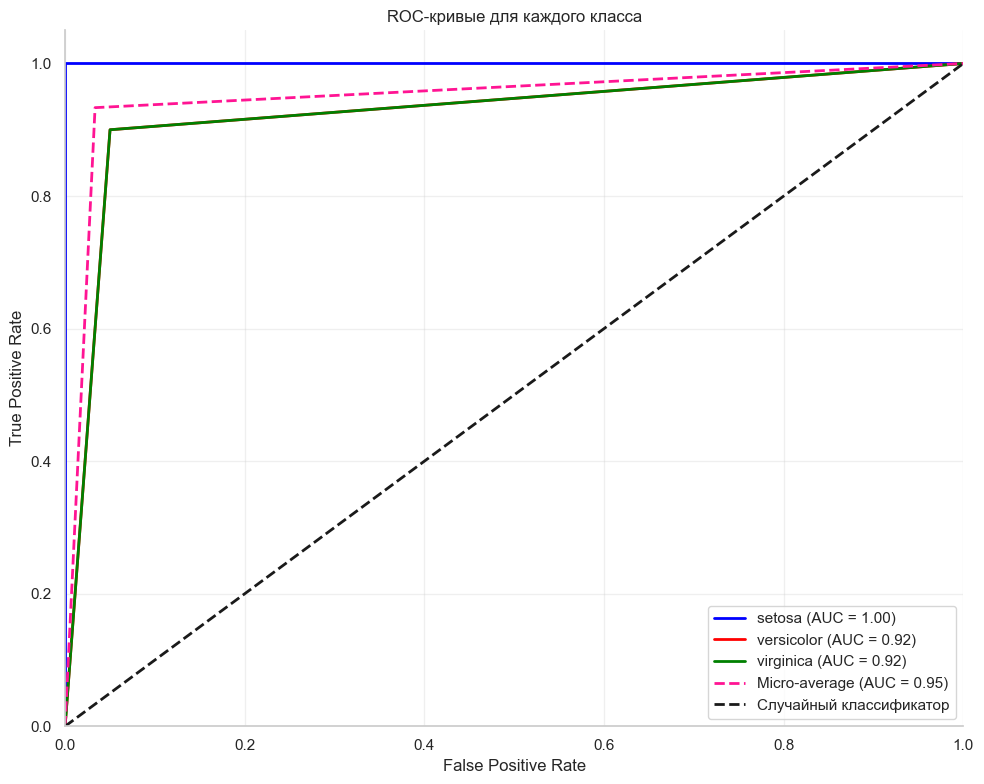

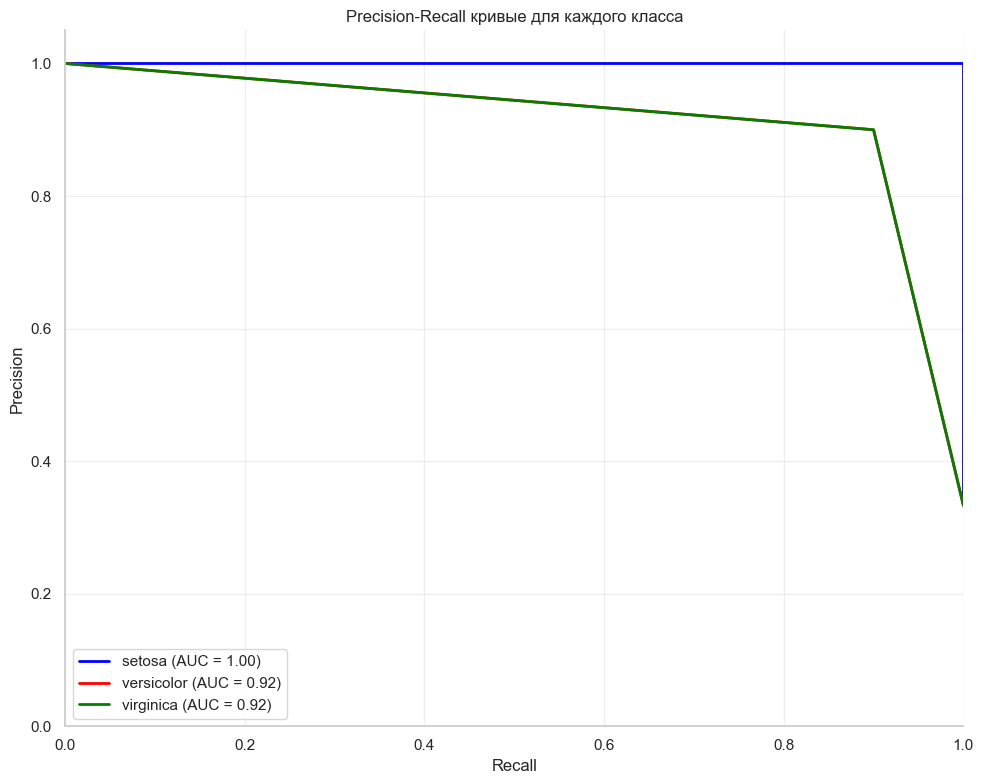

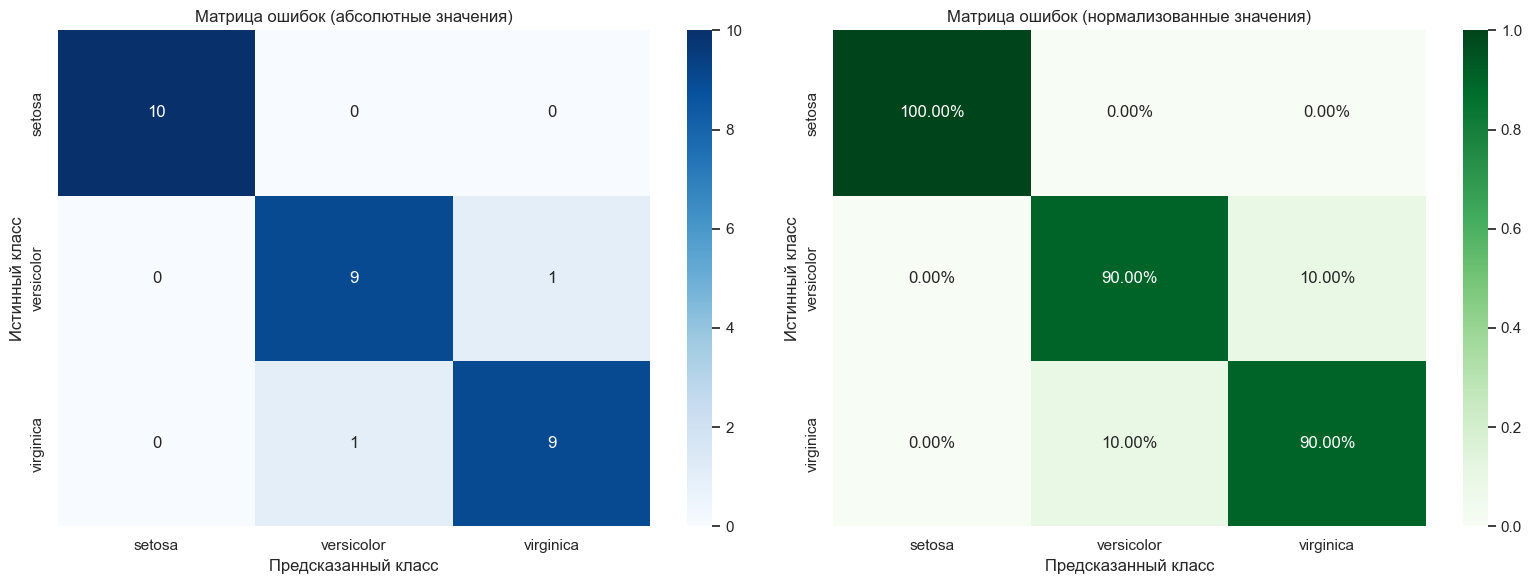


АНАЛИЗ ПРОИЗВОДИТЕЛЬНОСТИ ПО КЛАССАМ

SETOSA:
  Точность: 100.00%
  Количество примеров: 10
  Правильно классифицировано: 10
  Ошибочно классифицировано: 0

VERSICOLOR:
  Точность: 90.00%
  Количество примеров: 10
  Правильно классифицировано: 9
  Ошибочно классифицировано: 1

VIRGINICA:
  Точность: 90.00%
  Количество примеров: 10
  Правильно классифицировано: 9
  Ошибочно классифицировано: 1

КРОСС-ВАЛИДАЦИЯ С РАЗНЫМ КОЛИЧЕСТВОМ ФОЛДОВ

3-fold CV:
  Средняя точность: 0.9417 (±0.0118)
  Min: 0.9250, Max: 0.9500

5-fold CV:
  Средняя точность: 0.9417 (±0.0204)
  Min: 0.9167, Max: 0.9583

7-fold CV:
  Средняя точность: 0.9500 (±0.0375)
  Min: 0.8824, Max: 1.0000

10-fold CV:
  Средняя точность: 0.9583 (±0.0417)
  Min: 0.9167, Max: 1.0000


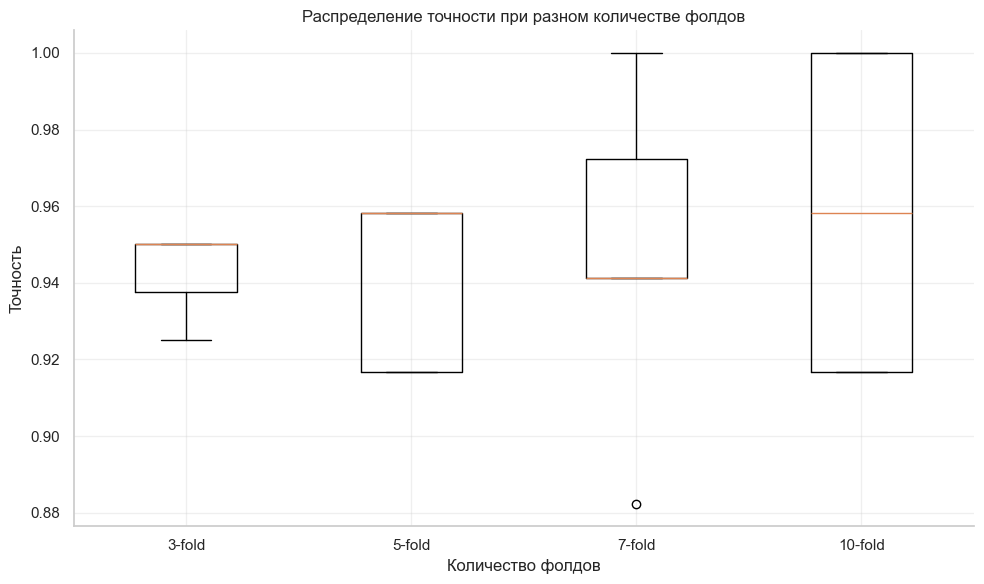


СРАВНЕНИЕ С ДРУГИМИ АЛГОРИТМАМИ КЛАССИФИКАЦИИ

Decision Tree (Optimized):
  Точность на тесте: 0.9333
  CV: 0.9417 (±0.0204)

Random Forest:
  Точность на тесте: 0.9000
  CV: 0.9500 (±0.0167)

K-Nearest Neighbors:
  Точность на тесте: 1.0000
  CV: 0.9750 (±0.0333)

SVM:
  Точность на тесте: 0.9667
  CV: 0.9750 (±0.0204)

Naive Bayes:
  Точность на тесте: 0.9667
  CV: 0.9583 (±0.0264)


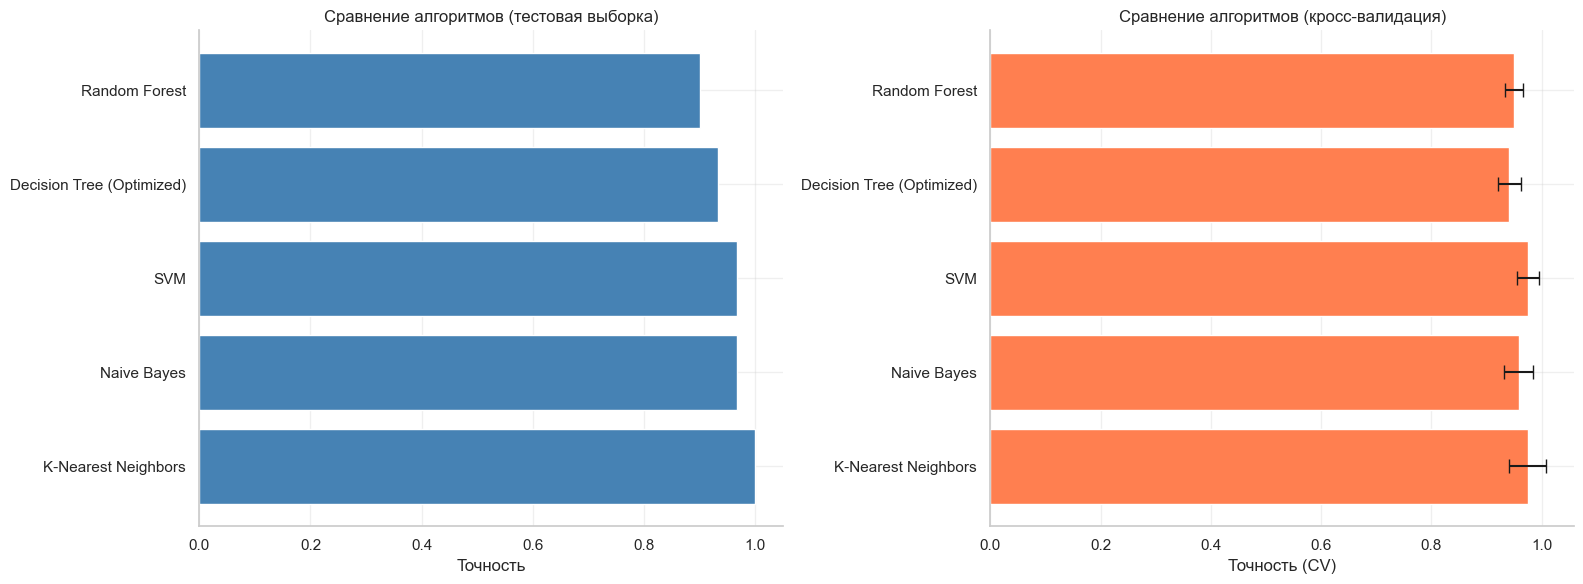


ИТОГОВЫЙ АНАЛИЗ

✓ Лучшая модель: K-Nearest Neighbors
✓ Точность: 1.0000

Важные метрики для данной задачи:


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC

# Построение кривых обучения для оптимизированной модели
train_sizes, train_scores, val_scores = learning_curve(
    best_tree_clf,
    X_train,
    y_train,
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy',
    random_state=42
)

# Вычисление средних значений и стандартных отклонений
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Визуализация кривых обучения
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Обучающая выборка', marker='o', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_mean, label='Валидационная выборка', marker='s', color='red')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')
plt.xlabel('Размер обучающей выборки')
plt.ylabel('Точность')
plt.title('Кривые обучения оптимизированной модели')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# Анализ переобучения
print(f"Точность на обучающей выборке: {train_mean[-1]:.4f} ± {train_std[-1]:.4f}")
print(f"Точность на валидационной выборке: {val_mean[-1]:.4f} ± {val_std[-1]:.4f}")
print(f"Разница (признак переобучения): {train_mean[-1] - val_mean[-1]:.4f}")

if train_mean[-1] - val_mean[-1] > 0.05:
    print("⚠️ Присутствуют признаки переобучения")
else:
    print("✓ Переобучение не обнаружено")

# ROC-кривая для мультиклассовой классификации

# Бинаризация целевой переменной для ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_score = best_tree_clf.predict_proba(X_test)

# Вычисление ROC-кривой и AUC для каждого класса
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC curve
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Визуализация ROC-кривых
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{target_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle='--', lw=2,
         label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Случайный классификатор')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для каждого класса')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Precision-Recall кривые
precision = dict()
recall = dict()
pr_auc = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'{target_names[i]} (AUC = {pr_auc[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall кривые для каждого класса')
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Детальная матрица ошибок с процентами
cm_best_detailed = confusion_matrix(y_test, y_pred_best)
cm_normalized = cm_best_detailed.astype('float') / cm_best_detailed.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Абсолютные значения
sns.heatmap(cm_best_detailed, annot=True, fmt='d', cmap='Blues',
           xticklabels=target_names, yticklabels=target_names, ax=axes[0])
axes[0].set_title('Матрица ошибок (абсолютные значения)')
axes[0].set_ylabel('Истинный класс')
axes[0].set_xlabel('Предсказанный класс')

# Нормализованные значения
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens',
           xticklabels=target_names, yticklabels=target_names, ax=axes[1])
axes[1].set_title('Матрица ошибок (нормализованные значения)')
axes[1].set_ylabel('Истинный класс')
axes[1].set_xlabel('Предсказанный класс')

plt.tight_layout()
plt.show()

# Анализ производительности по классам
print("\n" + "="*60)
print("АНАЛИЗ ПРОИЗВОДИТЕЛЬНОСТИ ПО КЛАССАМ")
print("="*60)

for i, class_name in enumerate(target_names):
    class_precision = cm_normalized[i, i]
    class_support = cm_best_detailed[i].sum()
    print(f"\n{class_name.upper()}:")
    print(f"  Точность: {class_precision:.2%}")
    print(f"  Количество примеров: {class_support}")
    print(f"  Правильно классифицировано: {cm_best_detailed[i, i]}")
    print(f"  Ошибочно классифицировано: {class_support - cm_best_detailed[i, i]}")

# Cross-validation с разным количеством фолдов
print("\n" + "="*60)
print("КРОСС-ВАЛИДАЦИЯ С РАЗНЫМ КОЛИЧЕСТВОМ ФОЛДОВ")
print("="*60)

cv_folds = [3, 5, 7, 10]
cv_results = {}

for n_folds in cv_folds:
    scores = cross_val_score(best_tree_clf, X_train, y_train, cv=n_folds, scoring='accuracy')
    cv_results[n_folds] = scores
    print(f"\n{n_folds}-fold CV:")
    print(f"  Средняя точность: {scores.mean():.4f} (±{scores.std():.4f})")
    print(f"  Min: {scores.min():.4f}, Max: {scores.max():.4f}")

# Визуализация результатов кросс-валидации
plt.figure(figsize=(10, 6))
plt.boxplot([cv_results[k] for k in cv_folds], labels=[f'{k}-fold' for k in cv_folds])
plt.xlabel('Количество фолдов')
plt.ylabel('Точность')
plt.title('Распределение точности при разном количестве фолдов')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Сравнение с другими алгоритмами классификации
print("\n" + "="*60)
print("СРАВНЕНИЕ С ДРУГИМИ АЛГОРИТМАМИ КЛАССИФИКАЦИИ")
print("="*60)

classifiers = {
    'Decision Tree (Optimized)': best_tree_clf,
    'Random Forest': RandomForestClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'SVM': SVC(probability=True, random_state=42),
    'Naive Bayes': GaussianNB()
}

comparison_results = []

for name, clf in classifiers.items():
    if name != 'Decision Tree (Optimized)':
        clf.fit(X_train, y_train)
    
    y_pred_clf = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred_clf)
    cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    
    comparison_results.append({
        'Алгоритм': name,
        'Точность на тесте': acc,
        'CV mean': cv_scores.mean(),
        'CV std': cv_scores.std()
    })
    
    print(f"\n{name}:")
    print(f"  Точность на тесте: {acc:.4f}")
    print(f"  CV: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Визуализация сравнения алгоритмов
comparison_df = pd.DataFrame(comparison_results)
comparison_df = comparison_df.sort_values('Точность на тесте', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Точность на тестовой выборке
axes[0].barh(comparison_df['Алгоритм'], comparison_df['Точность на тесте'], color='steelblue')
axes[0].set_xlabel('Точность')
axes[0].set_title('Сравнение алгоритмов (тестовая выборка)')
axes[0].grid(True, alpha=0.3)

# CV mean с error bars
axes[1].barh(comparison_df['Алгоритм'], comparison_df['CV mean'], 
            xerr=comparison_df['CV std'], color='coral', capsize=5)
axes[1].set_xlabel('Точность (CV)')
axes[1].set_title('Сравнение алгоритмов (кросс-валидация)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("ИТОГОВЫЙ АНАЛИЗ")
print("="*60)
print(f"\n✓ Лучшая модель: {comparison_df.iloc[0]['Алгоритм']}")
print(f"✓ Точность: {comparison_df.iloc[0]['Точность на тесте']:.4f}")
print(f"\nВажные метрики для данной задачи:")

## Дополнительные задания

1. **Обработка несбалансированных данных:**
   - Создайте несбалансированный датасет (удалив часть примеров одного класса)
   - Примените техники работы с несбалансированными данными
   - Сравните результаты

2. **Pruning (обрезка дерева):**
   - Реализуйте post-pruning для вашего дерева
   - Сравните производительность до и после обрезки

3. **Визуализация решений:**
   - Создайте функцию для отображения пути принятия решений для конкретного примера
   - Визуализируйте области решений на плоскости (для 2 признаков)

4. **Сравнение с ансамблями:**
   - Сравните ваше лучшее дерево с Random Forest
   - Проанализируйте различия в производительности и интерпретируемости

In [7]:
# Ваш код для дополнительных заданий
